In [5]:
import os, sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from util import basic
print("Done!")

Done!


In [6]:
import pandas as pd

In [4]:
x = torch.randn(2, 3, 5)
print(x)
print(x.size())
y = x.permute(1, 0, 2)
print(y.size())
print(y)

tensor([[[ 0.4273, -0.5860, -1.1210, -2.2975,  0.3159],
         [-1.1645,  0.1066, -1.5642,  2.6369,  1.5461],
         [-0.8413,  0.7559,  0.2563,  0.6071, -2.2008]],

        [[ 0.0217, -1.1420, -1.8345, -0.5267, -0.3057],
         [ 0.7530,  1.3931,  1.4808,  0.2028,  0.0197],
         [-1.0759, -1.6855,  1.3726,  0.0447, -0.9492]]])
torch.Size([2, 3, 5])
torch.Size([3, 2, 5])
tensor([[[ 0.4273, -0.5860, -1.1210, -2.2975,  0.3159],
         [ 0.0217, -1.1420, -1.8345, -0.5267, -0.3057]],

        [[-1.1645,  0.1066, -1.5642,  2.6369,  1.5461],
         [ 0.7530,  1.3931,  1.4808,  0.2028,  0.0197]],

        [[-0.8413,  0.7559,  0.2563,  0.6071, -2.2008],
         [-1.0759, -1.6855,  1.3726,  0.0447, -0.9492]]])


In [26]:
original_pos_data, original_pos_label = basic.preprocess_data("/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/gene_range_start_codon.txt", 1)
original_neg_data, original_neg_label = basic.preprocess_data("/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/intragenic_start_codon.txt", 0)

In [27]:
#pos_data = dataset.loc[dataset.label == 1].gene.values
#pos_label = dataset.loc[dataset.label == 1].label.values

In [28]:
#neg_data = dataset.loc[dataset.label == 0].gene.values
#neg_label = dataset.loc[dataset.label == 0].label.values

In [31]:
print(len(original_pos_data), len(original_neg_data))
print(original_pos_label[0], original_neg_label[0])

1527294 2242562
1 0


In [32]:
data_size = 1000
batch_size = 10
data_content = original_pos_data[:data_size] + original_neg_data[:data_size]
pos_data = None
neg_data = None
data_label = original_pos_label[:data_size] + original_neg_label[:data_size] 
pos_label = None
neg_label = None
print(len(data_content), np.sum(data_label))

total_datasize = len(data_content)-len(data_content)%batch_size
print(total_datasize, batch_size)
rand_index = np.random.permutation(total_datasize)
data_content = [data_content[i] for i in rand_index]
data_label = [data_label[i] for i in rand_index]
print(len(data_content), np.sum(data_label))
# '''
# for i in range(len(data_label)):
#     if data_label[i] == 1:
#         data_content[i] = [data_content[i][0] for k in data_content[i]]
# '''

2000 1000
2000 10
2000 1000


In [33]:
#data_content[0]

## Pytorch Basic Attention model

In [34]:
X = torch.from_numpy(np.array(data_content).astype(int))
Y = torch.from_numpy(np.array(data_label).reshape(len(data_label),1).astype(np.int))
X.shape, Y.shape

(torch.Size([2000, 101]), torch.Size([2000, 1]))

In [42]:
class AttnDecoderRNN(nn.Module):#corrected batch faster
    #(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch)
    def __init__(self, vocab_size, embedding_dim, \
                 hidden_dim, batch_size=100, debug=1, \
                 tagset_size=1, time_steps=101):
        super(AttnDecoderRNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.minibatch_size = batch_size
        self.dropout_p = 0.25
        self.tagset_size = tagset_size
        self.hidden = self.init_hidden()
        self.debug = debug

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_one = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout_one = nn.Dropout(0.25)
        self.lstm_two = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout_two = nn.Dropout(0.25)
        
        self.attn_array = [nn.Linear(hidden_dim, hidden_dim) for i in range(time_steps)]
        """
        self.attn_combine = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(hidden_dim, 1)
        #embedding_dim*time_steps
        """
        
        self.hidden2tag_one = nn.Linear(hidden_dim*time_steps, 512)
        self.dropout_three = nn.Dropout(0.25)
        self.hidden2tag_two = nn.Linear(512, 128)
        self.dropout_four = nn.Dropout(0.25)
        self.hidden2tag_three = nn.Linear(128, 64)
        self.dropout_five = nn.Dropout(0.25)
        
        self.output = nn.Linear(64, tagset_size)

    def forward(self, input):
        init_embed = self.embedding(input)
        #embedded = init_embed.permute(1, 0, 2)
        if self.debug == 1:
            print("Embedding Shape: ", init_embed.shape)
        
        lstm_out, self.hidden_one = self.lstm_one(init_embed, self.hidden)
        lstm_out = self.dropout_one(lstm_out)
        lstm_out, self.hidden_two = self.lstm_two(lstm_out, self.hidden)
        lstm_out = self.dropout_two(lstm_out)
        #"""
        lstm_permute = lstm_out.permute(1, 0, 2)
        if self.debug == 1:
            print("LSTM Out Shape: ", lstm_permute.shape)
        
        attention = [self.attn_array[i](lstm_permute[i][:]) \
                     for i in range(self.time_steps)]
        attention = torch.stack(attention)
        attention = attention.permute(1, 0, 2)
        if self.debug == 1:
            print("Attention Shape: ", attention.shape)
        
        attn_weights = F.softmax(attention, dim=2)
        #attn_weights = attn_weights.view(self.minibatch_size, self.time_steps, 1)
        if self.debug == 1:
            print("Softmax Shape: ", attn_weights.shape)
        """
        attn_weights = torch.stack(
            [attn_weights]*self.embedding_dim, 2).view(
            self.minibatch_size, self.time_steps, -1)
        if self.debug == 1:
            print("Softmax ReShape: ", attn_weights.shape)
        """
        #attn_applied = init_embed
        attn_applied = attn_weights * init_embed
        #attn_applied = attn_applied.view(self.minibatch_size, self.time_steps, -1)
        #attn_applied = torch.sum(attn_applied, dim=1)
        if self.debug == 1:
            print("Embedding*Attention Shape: ", attn_applied.shape)
        
        #output = F.relu(attn_applied)
        #"""
        
        lstm_out = attn_applied.contiguous().view(self.minibatch_size, -1)
        #lstm_output = lstm_out.contiguous().view(self.minibatch_size, -1)
        if self.debug == 1:
            print("LSTM Output Shape: ", lstm_out.shape)
        
        
        dense_out = self.hidden2tag_one(lstm_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_three(dense_out[:])
        
        dense_out = self.hidden2tag_two(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_four(dense_out[:])
        
        dense_out = self.hidden2tag_three(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_five(dense_out[:])
        
        tag_space = self.output(dense_out[:])
        #print(tag_space.shape)
        #tag_scores = F.sigmoid(tag_space)
        #tag_scores = F.softmax(tag_space, dim=1)
        #print(tag_scores.shape)
        return tag_space, attn_applied

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.minibatch_size, self.hidden_dim),
                torch.zeros(1, self.minibatch_size, self.hidden_dim))

In [43]:
model = AttnDecoderRNN(5, 16, 16)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

AttnDecoderRNN(
  (embedding): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (hidden2tag_one): Linear(in_features=1616, out_features=512, bias=True)
  (dropout_three): Dropout(p=0.25)
  (hidden2tag_two): Linear(in_features=512, out_features=128, bias=True)
  (dropout_four): Dropout(p=0.25)
  (hidden2tag_three): Linear(in_features=128, out_features=64, bias=True)
  (dropout_five): Dropout(p=0.25)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [44]:
print(X[:100].shape)
with torch.no_grad():
    output, attn_weights = model(X[:100])
    print(output.shape, attn_weights.shape)

torch.Size([100, 101])
Embedding Shape:  torch.Size([100, 101, 16])
LSTM Out Shape:  torch.Size([101, 100, 16])
Attention Shape:  torch.Size([100, 101, 16])
Softmax Shape:  torch.Size([100, 101, 16])
Embedding*Attention Shape:  torch.Size([100, 101, 16])
LSTM Output Shape:  torch.Size([100, 1616])
torch.Size([100, 1]) torch.Size([100, 101, 16])


In [45]:
def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:
        assert len(weights) == 2
        
        output = torch.clamp(output,min=1e-8,max=1-1e-8) 
        #loss =  pos_weight * (target * torch.log(output)) + \
        #        neg_weight * ((1 - target) * torch.log(1 - output))
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [46]:
import torch.nn.functional as F

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    
    return acc

In [47]:
from tqdm import tqdm_notebook as tqdm
losses = []
accuracies = []
#batch_size = 10
model = AttnDecoderRNN(5, 16, 16, batch_size=batch_size, debug=0)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 40
for epoch in tqdm(range(num_epochs)):  # again, normally you would NOT do 300 epochs, it is toy data
    total_loss = 0
    total_acc = 0
    
    for index in range(0, len(X), batch_size):
        sentence = X[index : index+batch_size]#.reshape(len(X[0]))
        tags = Y[index : index+batch_size]#.reshape(len(Y[0]))
        #print(sentence.shape, tags.shape)
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        #targets = prepare_sequence(tags, tag_to_ix)
        targets = tags.float().flatten()

        # Step 3. Run our forward pass.
        tag_scores, attn_weight = model(sentence)
        tag_scores = tag_scores.flatten()
        #print(targets.shape, tag_scores.shape)
        
        #neg_weight = batch_size / (batch_size-np.sum(data_label[index : index+batch_size]))
        #pos_weight = batch_size / np.sum(data_label[index : index+batch_size])
        #weights = torch.FloatTensor([neg_weight, pos_weight])
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(tag_scores, targets)
        #loss = weighted_binary_cross_entropy(tag_scores, targets, weights=weights)
        total_loss += loss.data.numpy()
        
        acc = binary_accuracy(tag_scores, targets)
        total_acc += acc
        
        loss.backward()
        optimizer.step()
        
        #print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.data[0], correct/x.shape[0]))
        
    losses.append(total_loss)
    accuracies.append(total_acc/(len(X)/batch_size))
    
    #total_loss.backward()
    #opt.step()
    
    #print(epoch, total_loss)#, total_acc)
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, losses[-1], accuracies[-1]))
        
    
        

AttnDecoderRNN(
  (embedding): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (hidden2tag_one): Linear(in_features=1616, out_features=512, bias=True)
  (dropout_three): Dropout(p=0.25)
  (hidden2tag_two): Linear(in_features=512, out_features=128, bias=True)
  (dropout_four): Dropout(p=0.25)
  (hidden2tag_three): Linear(in_features=128, out_features=64, bias=True)
  (dropout_five): Dropout(p=0.25)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/40, Loss: 83.142, Accuracy: 0.798
Epoch 2/40, Loss: 44.911, Accuracy: 0.907
Epoch 3/40, Loss: 36.505, Accuracy: 0.932
Epoch 4/40, Loss: 31.329, Accuracy: 0.935
Epoch 5/40, Loss: 23.465, Accuracy: 0.956
Epoch 6/40, Loss: 16.480, Accuracy: 0.969
Epoch 7/40, Loss: 15.927, Accuracy: 0.971
Epoch 8/40, Loss: 8.794, Accuracy: 0.984
Epoch 9/40, Loss: 8.798, Accuracy: 0.981
Epoch 10/40, Loss: 3.127, Accuracy: 0.993
Epoch 11/40, Loss: 5.358, Accuracy: 0.991
Epoch 12/40, Loss: 4.445, Accuracy: 0.993
Epoch 13/40, Loss: 4.742, Accuracy: 0.991
Epoch 14/40, Loss: 3.639, Accuracy: 0.994
Epoch 15/40, Loss: 0.582, Accuracy: 0.999
Epoch 16/40, Loss: 1.536, Accuracy: 0.998
Epoch 17/40, Loss: 1.852, Accuracy: 0.995
Epoch 18/40, Loss: 3.896, Accuracy: 0.996


KeyboardInterrupt: 

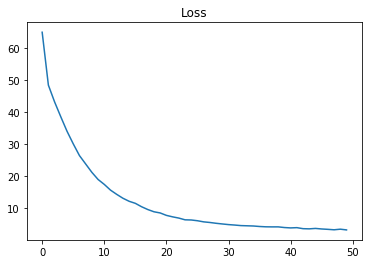

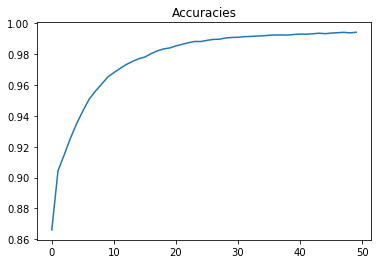

In [16]:
plt.title("Loss")
plt.plot(losses)
plt.show()
plt.title("Accuracies")
plt.plot(accuracies)
plt.show()